<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [88]:
#prepare the dataset for total disabled people by regions
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()
disabled

,Lower tier local authorities,Observation
0,Adur,12577
1,Allerdale,19205
2,Amber Valley,25066
3,Arun,32481
4,Ashfield,27809
...,...,...
304,Worthing,21303
305,Wychavon,22955
306,Wyre,24771
307,Wyre Forest,20459


In [89]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']]
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')]

filtered_blue_badges


,Local Authority,Total valid Blue Badges held by organisations and individuals
2,County Durham,27.884
3,Darlington,5.945
4,Hartlepool,5.530
5,Middlesbrough,6.546
6,Northumberland,16.242
...,...,...
163,Wiltshire,23.267
164,Devon,41.387
165,Dorset,25.370
166,Gloucestershire,28.348


In [90]:
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')

# You may want to handle NaN values here, either by filling with a default value or dropping those rows
# For example, to drop rows with NaN values, uncomment the following line:
# filtered_blue_badges.dropna(subset=['Total valid Blue Badges held by organisations and individuals'], inplace=True)

# Now, multiply by 1000 and convert to integer
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] * 1000).astype(int)

filtered_blue_badges

<ipython-input-90-52c0b4b495e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')
<ipython-input-90-52c0b4b495e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by o

,Local Authority,Total valid Blue Badges held by organisations and individuals
2,County Durham,27884
3,Darlington,5945
4,Hartlepool,5530
5,Middlesbrough,6546
6,Northumberland,16242
...,...,...
163,Wiltshire,23267
164,Devon,41387
165,Dorset,25370
166,Gloucestershire,28348


In [91]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])
merged_data

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
0,County Durham,27884,County Durham,119790
1,Darlington,5945,Darlington,21104
2,Hartlepool,5530,Hartlepool,21145
3,Middlesbrough,6546,Middlesbrough,29520
4,Northumberland,16242,Northumberland,67190
...,...,...,...,...
102,South Gloucestershire,14238,South Gloucestershire,47429
103,Swindon,12615,Swindon,37075
104,Torbay,8325,Torbay,33224
105,Wiltshire,23267,Wiltshire,86495


## WE ARE MISSING LOCAL AUTHORITIES HERE

In [92]:

# List of 32 London local authorities
london_authorities = [
    "City of London", "City of Westminster", "Kensington and Chelsea",
    "Hammersmith and Fulham", "Wandsworth", "Lambeth", "Southwark",
    "Tower Hamlets", "Hackney", "Islington", "Camden", "Brent", "Ealing",
    "Hounslow", "Richmond upon Thames", "Kingston upon Thames", "Merton",
    "Sutton", "Croydon", "Bromley", "Lewisham", "Greenwich", "Bexley",
    "Havering", "Barking and Dagenham", "Redbridge", "Newham",
    "Waltham Forest", "Haringey", "Enfield", "Barnet", "Harrow", "Hillingdon"
]

# Filter the DataFrame to include only rows where 'Local Authority' matches the London authorities
london_data = merged_data[merged_data['Local Authority'].isin(london_authorities)]

# Display the filtered DataFrame
london_data


,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
56,Camden,6495,Camden,31882
57,City of London,146000,City of London,919
58,Haringey,8230,Haringey,36114
59,Islington,7730,Islington,35063
60,Kensington and Chelsea,2442,Kensington and Chelsea,18311
61,Southwark,6720,Southwark,42022
62,Tower Hamlets,7108,Tower Hamlets,40125
63,Wandsworth,6612,Wandsworth,37444
65,Barking and Dagenham,7519,Barking and Dagenham,28993
66,Barnet,15231,Barnet,49679


⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕  WHY IS 'City of London' containing only 919 observations?
i am now creating a dataframe exlcuding outliers - such as this one.

In [93]:
#OUTLIERS for 'Observation' (deleting City of London Outlier)

# Calculate Q1, Q3, and IQR
Q1 = london_data['Observation'].quantile(0.25)
Q3 = london_data['Observation'].quantile(0.75)
IQR = Q3 - Q1

# Define the range for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
london_data_no_outliers = london_data[(london_data['Observation'] >= lower_bound) & (london_data['Observation'] <= upper_bound)]

london_data_no_outliers

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
56,Camden,6495,Camden,31882
58,Haringey,8230,Haringey,36114
59,Islington,7730,Islington,35063
60,Kensington and Chelsea,2442,Kensington and Chelsea,18311
61,Southwark,6720,Southwark,42022
62,Tower Hamlets,7108,Tower Hamlets,40125
63,Wandsworth,6612,Wandsworth,37444
65,Barking and Dagenham,7519,Barking and Dagenham,28993
66,Barnet,15231,Barnet,49679
67,Bexley,9451,Bexley,36083


# **1. Summary Statistics**

In [94]:
reg_df= london_data_no_outliers.drop(['Lower tier local authorities'],axis=1)
reg_df['Local Authority']=reg_df['Local Authority'].astype('category')
reg_df.rename(columns={'Observation': 'Disable_population'}, inplace=True)
reg_df.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
reg_df

,Local Authority,Blue_Badges_population,Disable_population
56,Camden,6495,31882
58,Haringey,8230,36114
59,Islington,7730,35063
60,Kensington and Chelsea,2442,18311
61,Southwark,6720,42022
62,Tower Hamlets,7108,40125
63,Wandsworth,6612,37444
65,Barking and Dagenham,7519,28993
66,Barnet,15231,49679
67,Bexley,9451,36083


In [95]:
summary=reg_df.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,25.0,8413.04,2875.77,2442.0,6720.0,7730.0,10657.0,15231.0
Disable_population,25.0,36278.44,8659.34,18311.0,31258.0,36762.0,41576.0,54852.0


# **2. Visualization**
no need for that

# **3. Assumptions**

Text(87.72222222222221, 0.5, 'Blue Badges population')

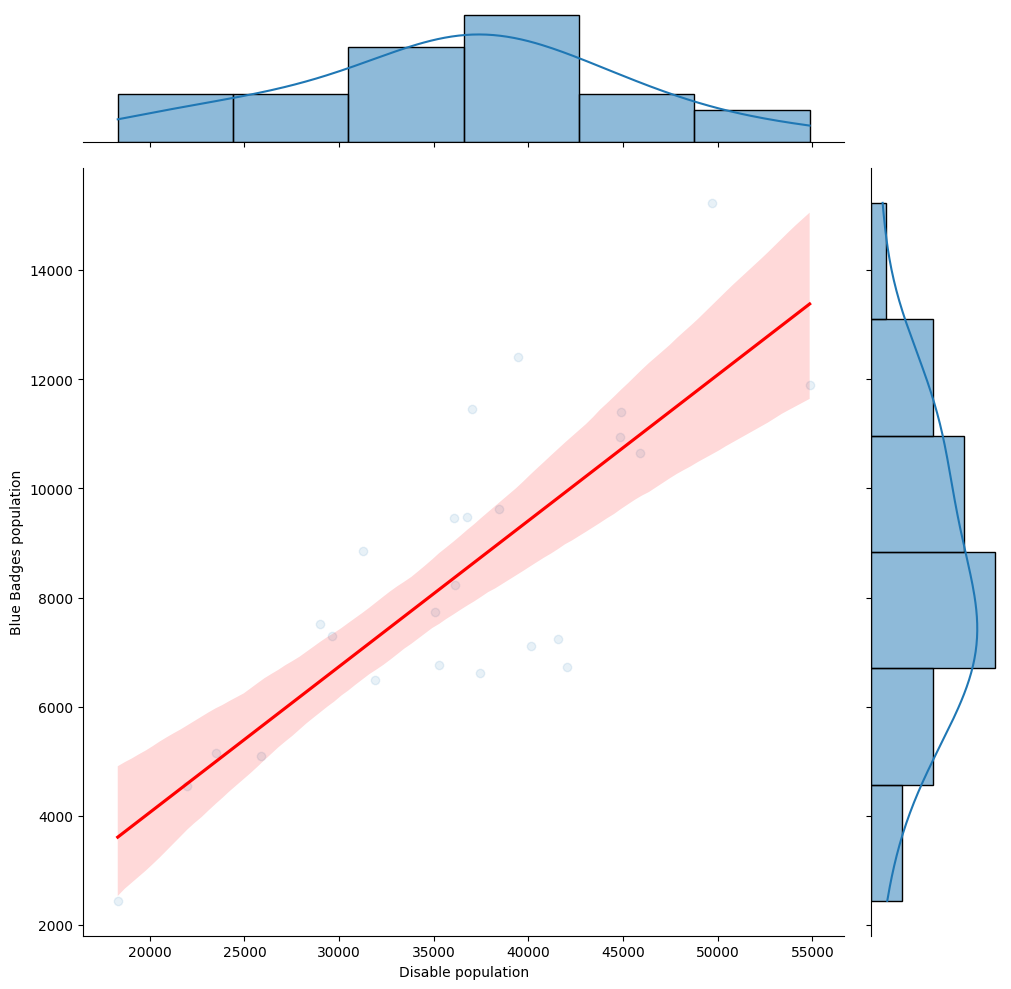

In [96]:
#Homoscedasticity
sns.jointplot(data=reg_df, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Blue_Badges_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Disable population') # add a label to the x axis
plt.ylabel('Blue Badges population') # add a label to the y axis

# **4. Regression**

In [100]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Blue_Badges_population ~  Disable_population', data=reg_df).fit() # fit the model
print(model.summary()) # print the summary

                              OLS Regression Results                              
Dep. Variable:     Blue_Badges_population   R-squared:                       0.648
Model:                                OLS   Adj. R-squared:                  0.633
Method:                     Least Squares   F-statistic:                     42.38
Date:                    Thu, 11 Jan 2024   Prob (F-statistic):           1.21e-06
Time:                            15:14:18   Log-Likelihood:                -221.01
No. Observations:                      25   AIC:                             446.0
Df Residuals:                          23   BIC:                             448.4
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕***WE HAVE TO REWRITE THE WHOLE OF THIS BECAUSE IT IS NOT APPLIED TO THE NEW LONDON FOCUSED CODE***. ⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕

1.The R-squared of 0.033 sugested that **only 3.3%% of the variation in blue badges population can be explained by the total disabled population**, imples that there could be more varables(loneliness, spread of transportation and accessibility of transportation and etc.) that affecting the blue badges population.

2.The coefficient of 0.0001 means **10000 unit increase in total diabled population will lead to 1 unit increase in blue badges population**


3.The p-value of 0.004 is less that 0.05, suggests that the coefficient is statistically significant at the 5% level and **we can reject the null hypothesis.**

# Transport Reliant Disabled People

In [106]:
# Convert columns to numeric
london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'])
london_data_no_outliers['Observation'] = pd.to_numeric( london_data_no_outliers['Observation'])

# Create the new column by subtracting the two columns
london_data_no_outliers['Transport reliant people with a disability estimate'] =  london_data_no_outliers['Observation'] -  london_data_no_outliers['Total valid Blue Badges held by organisations and individuals']
London_TR_data =  london_data_no_outliers

# Display the DataFrame
London_TR_data

<ipython-input-106-bfff857647d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'])
<ipython-input-106-bfff857647d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_data_no_outliers['Observation'] = pd.to_numeric( london_data_no_outliers['Observation'])
<ipython-input-106-bfff857647d0>:6: SettingWithCopyWarni

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation,Transport reliant people with a disability estimate
56,Camden,6495,Camden,31882,25387
58,Haringey,8230,Haringey,36114,27884
59,Islington,7730,Islington,35063,27333
60,Kensington and Chelsea,2442,Kensington and Chelsea,18311,15869
61,Southwark,6720,Southwark,42022,35302
62,Tower Hamlets,7108,Tower Hamlets,40125,33017
63,Wandsworth,6612,Wandsworth,37444,30832
65,Barking and Dagenham,7519,Barking and Dagenham,28993,21474
66,Barnet,15231,Barnet,49679,34448
67,Bexley,9451,Bexley,36083,26632


# Summary Statistics TRP

In [109]:
reg_df2= London_TR_data.drop(['Lower tier local authorities'],axis=1)
reg_df2 = reg_df2.drop('Total valid Blue Badges held by organisations and individuals', axis=1)

reg_df2['Local Authority']=reg_df['Local Authority'].astype('category')
reg_df2.rename(columns={'Observation': 'Disable_population'}, inplace=True)
reg_df2.rename(columns={'Transport reliant people with a disability estimate': 'Transport_Reliant_Disabled_population'}, inplace=True)

reg_df2

,Local Authority,Disable_population,Transport_Reliant_Disabled_population
56,Camden,31882,25387
58,Haringey,36114,27884
59,Islington,35063,27333
60,Kensington and Chelsea,18311,15869
61,Southwark,42022,35302
62,Tower Hamlets,40125,33017
63,Wandsworth,37444,30832
65,Barking and Dagenham,28993,21474
66,Barnet,49679,34448
67,Bexley,36083,26632


In [114]:
summary=reg_df2.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Disable_population,25.0,36278.44,8659.34,18311.0,31258.0,36762.0,41576.0,54852.0
Transport_Reliant_Disabled_population,25.0,27865.40,6569.26,15869.0,22408.0,27333.0,33479.0,42952.0


In [115]:
#SHOULD WE STILL DO OUTLIERS HERE?

# Assumptions

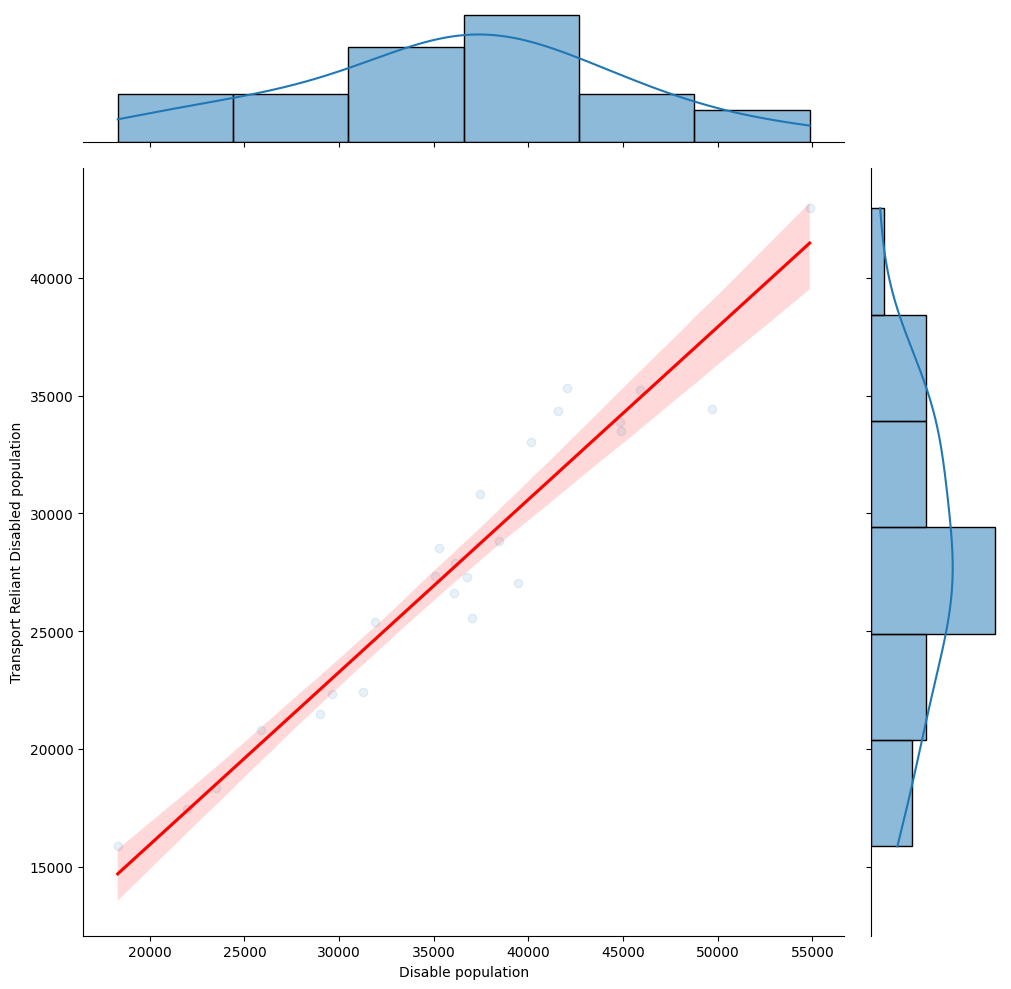

In [118]:
# Homoscedasticity
sns.jointplot(data=reg_df2,
              x='Disable_population',
              y='Transport_Reliant_Disabled_population', # Corrected the column name here
              kind="reg",
              scatter_kws=dict(alpha=0.1),
              line_kws=dict(color='red'),
              height=10)

plt.xlabel('Disable population')
plt.ylabel('Transport Reliant Disabled population') # Corrected the label here (optional: match the actual column name)

plt.show()  # To display the plot